In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from collections import OrderedDict
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
1.9.0


In [ ]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        n_hidden = len(layers) 
        self.activation = nn.Tanh
        layer_list = []

        for i in range(n_hidden-2):

            linear = torch.nn.Linear(layers[i], layers[i+1])

            nn.init.xavier_normal_(linear.weight.data, gain=1.0)
            nn.init.zeros_(linear.bias.data)

            layer_list.append(
                ('layer_%d' % i, linear)
            )
            layer_list.append(
                ('activation_%d' % i, self.activation())
            )
        
        linear = torch.nn.Linear(layers[n_hidden-2], layers[n_hidden-1])
        nn.init.xavier_normal_(linear.weight.data, gain=1.0)
        nn.init.zeros_(linear.bias.data)

        layer_list.append(('layer_%d' % (n_hidden-2), linear))
        
        layerDict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [25]:
class PINN_Burgers:
    
    def __init__(self, net, Xt, Y, lb, ub, device):
        
        # data
        self.X = Xt[:,0:1]; self.t = Xt[:,1:2]
        self.Y = torch.tensor(Y).float().to(device)
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # net
        self.net = net.to(device)
        
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        self.net.register_parameter('lambda_1', self.lambda_1)
        self.net.register_parameter('lambda_2', self.lambda_2)

        # opt: using both Adam and LBFGS
        self.opt_LBFGS = optim.LBFGS(
            self.net.parameters(), 
            lr=1., 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        self.iter = 0
        self.opt_Adam = optim.Adam(self.net.parameters(), lr=0.003)

    def net_U(self, x, t):
        xt = torch.cat((x,t), dim=1)
        xt = 2*(xt-self.lb)/(self.ub-self.lb) - 1
        u = self.net(xt)
        return u

    def net_F(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)

        u = self.net_U(x, t)

        u_t = torch.autograd.grad(u, t, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), 
                                    retain_graph=True,
                                    create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]
      
        F = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return F

    def _train_step(self):
        
        X = torch.tensor(self.X, requires_grad=True).float().to(device)
        t = torch.tensor(self.t, requires_grad=True).float().to(device)
        
        u_pred = self.net_U(X, t)
        f_pred = self.net_F(X, t)
        loss = torch.mean((self.Y-u_pred)**2) + torch.mean(f_pred**2)

        return loss

    def _closure(self):
        loss = self._train_step()
        self.opt_LBFGS.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 200 == 0:
            print('epoch: {}  loss: {:.3e}  lam_1: {:4f}  lam_2: {:.6f}'.format(self.iter, 
                                                                                loss.item(),
                                                                                self.lambda_1.item(),
                                                                                torch.exp(self.lambda_2).item()))
        return loss

    def train(self, epochs):
        self.net.train() # training mode
        for epoch in range(epochs):
            
            loss = self._train_step() 
            
            self.opt_Adam.zero_grad()
            loss.backward()
            self.opt_Adam.step()

            if (epoch+1) % 200 == 0:
                print('epoch: {}  loss: {:.3e}  lam_1: {:4f}  lam_2: {:.6f}'.format(epoch+1, 
                                                                                    loss.item(),
                                                                                    self.lambda_1.item(),
                                                                                    torch.exp(self.lambda_2).item()))
        self.opt_LBFGS.step(self._closure)

    def predict(self, x):
        
        x = torch.tensor(x, requires_grad=True).float().to(device)
    
        self.net.eval()
       
        u_pred = self.net_U(x[:,0:1], x[:,1:2])
        
        return u_pred.detach().cpu().numpy()
        




In [26]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

import scipy.io
data = scipy.io.loadmat('./Data/burgers_shock.mat')

t = data['t'].flatten()[:,None] # 100 x 1
x = data['x'].flatten()[:,None] # 256 x 1
Exact = np.real(data['usol']).T # 100 x 256

X, T = np.meshgrid(x,t) # 100 x 256

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # 25600 x 2
u_star = Exact.flatten()[:,None] # 25600 x 1         

# Domain bounds of x, t
lb = X_star.min(0)
ub = X_star.max(0)   

# training data
noise = 0.0            
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]




In [5]:
net = DNN(layers)
net

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=20, bias=True)
    (activation_6): Tanh()
    (layer_7): Linear(in_features=20, out_features=20, bias=True)
    (activation_7): Tanh()
    (layer_8): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [6]:
pinn = PINN_Burgers(net, X_u_train, u_train, lb, ub, device)
pinn.train(0) 

epoch: 200  loss: 4.549e-03  lam_1: 0.783027  lam_2: 0.003320
epoch: 400  loss: 7.798e-04  lam_1: 0.956571  lam_2: 0.003983
epoch: 600  loss: 2.600e-04  lam_1: 0.985492  lam_2: 0.003865
epoch: 800  loss: 1.264e-04  lam_1: 0.993774  lam_2: 0.003530
epoch: 1000  loss: 8.076e-05  lam_1: 0.997295  lam_2: 0.003316
epoch: 1200  loss: 5.712e-05  lam_1: 0.997658  lam_2: 0.003203
epoch: 1400  loss: 4.128e-05  lam_1: 0.998228  lam_2: 0.003139
epoch: 1600  loss: 2.833e-05  lam_1: 0.999384  lam_2: 0.003129
epoch: 1800  loss: 2.279e-05  lam_1: 0.996350  lam_2: 0.003165
epoch: 2000  loss: 1.945e-05  lam_1: 0.999048  lam_2: 0.003177
epoch: 2200  loss: 1.672e-05  lam_1: 0.999261  lam_2: 0.003205
epoch: 2400  loss: 1.469e-05  lam_1: 0.999951  lam_2: 0.003235
epoch: 2600  loss: 1.220e-05  lam_1: 0.999948  lam_2: 0.003229
epoch: 2800  loss: 1.038e-05  lam_1: 0.999601  lam_2: 0.003199
epoch: 3000  loss: 8.912e-06  lam_1: 0.998588  lam_2: 0.003175
epoch: 3200  loss: 7.912e-06  lam_1: 0.999535  lam_2: 0.003

In [7]:
error_lambda_1 = np.abs(pinn.lambda_1.detach().cpu().numpy() - 1.0)/1*100
error_lambda_2 = np.abs(np.exp(pinn.lambda_2.detach().cpu().numpy()) - nu)/nu * 100
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))

Error l1: 0.02003%
Error l2: 0.28530%


In [8]:
u_pred = pinn.predict(X_star)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))  

Error u: 2.902313e-03


Text(0.5, 1.0, '$t = 0.75$')

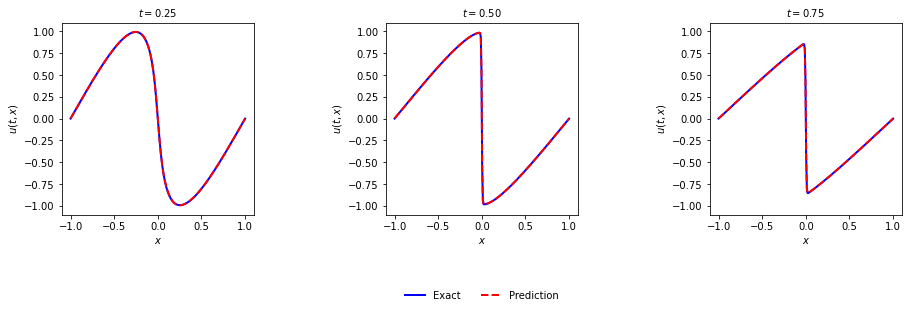

In [9]:
# testing data at t = 0.25, 0.5, 0.75
X_u_test_25 = np.hstack([x, 0.25*np.ones_like((x))]); u_test_25 = Exact[25]
X_u_test_50 = np.hstack([x, 0.50*np.ones_like((x))]); u_test_50 = Exact[50]
X_u_test_75 = np.hstack([x, 0.75*np.ones_like((x))]); u_test_75 = Exact[75]

u_pred_25 = pinn.predict(X_u_test_25)
u_pred_50 = pinn.predict(X_u_test_50)
u_pred_75 = pinn.predict(X_u_test_75)

fig = plt.figure(figsize=(15,4))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred_25, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred_50, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,u_pred_75, 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)